# Long short-term memory
___

This model is based on:

```Bibtex
@inproceedings{daxenbergerWhatEssenceClaim2017,
  title = {What Is the Essence of a Claim? {{Cross-domain}} Claim Identification},
  author = {Daxenberger, Johannes and Eger, Steffen and Habernal, Ivan and Stab, Christian and Gurevych, Iryna},
  date = {2017},
  doi = {10.18653/v1/d17-1218},
}
```

In [1]:
from google.colab import drive

In [76]:
drive.mount('/content/drive')  # connect to google drive
base_dir = "drive/MyDrive/claim_model_comparison"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
%%capture
!pip install tensorflow_text
!pip install wandb

In [93]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import LSTM, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from wandb.keras import WandbCallback

import wandb

In [79]:
def load_dataset(dataset_path: str, split_size: float=0.2, false_class_balance: float=1.0) -> pd.DataFrame:
    """Function to load the dataset.

    Returns:
        X_train (DatFrame): Train data
        X_test (DatFrame): Test data
        y_train (DatFrame): Train label
        y_test (DatFrame): Test label
    """
    data = pd.read_csv(os.path.join(dataset_path))  # load Data

    claims = data[data["Claim"] == True]

    n_samples = int(len(claims) * false_class_balance)
    no_claims = data[data["Claim"] == False].sample(n=n_samples, random_state=42)
    data_sample = pd.concat([claims, no_claims])

    X_train, X_test, y_train, y_test = train_test_split(
        data_sample, data_sample["Claim"], test_size=split_size, random_state=0
    )
    return X_train, X_test, y_train, y_test

In [107]:
MODEL_NAME = "LSTM"
TRACKING = True
FALSE_CLASS_BALANCE = 1.0
DATASET_2014_PATH = os.path.join(base_dir, "CE-ACL_processed.csv")
DATASET_2018_PATH = os.path.join(base_dir, "claim_sentence_search.csv")
DATASET_2014_NAME = "IBM_Debater_(R)_CE-ACL-2014.v0"
DATASET_2018_NAME = "IBM_Debater_(R)_claim_sentences_search"
PROJECT_NAME = "Claim detection models"

### 0. Load data

In [108]:
X_train, X_test, y_train, y_test = load_dataset(dataset_path=DATASET_2014_PATH, false_class_balance=FALSE_CLASS_BALANCE)

In [110]:
y_train = y_train.apply(lambda x: 0 if x==False else 1)
y_test = y_test.apply(lambda x: 0 if x==False else 1)

### 1. Create embeddings

In [111]:
max_words = 5000  # consider the top n words in the data set only
maxlen = len(X_train["Sentence"].max())  # longest sentence to calculate max embedding len

tokenizer = Tokenizer(num_words=max_words)  # create tokanizer
tokenizer.fit_on_texts(X_train["Sentence"])  # tokenize sentences

def create_embeddings(data, labels):
  sequences = tokenizer.texts_to_sequences(data["Sentence"]) # get sequences for sentences

  data = pad_sequences(sequences, maxlen=maxlen) # padding for shorter sentences
  labels = np.asarray(labels) # return labels

  # reporting
  word_index = tokenizer.word_index
  print('Found %s unique tokens' % len(word_index))
  print('Shape of data tensor:', data.shape)
  print('Shape of label tensor:', labels.shape)

  return data, labels

### 2. Prepare dataset

In [112]:
X_train, y_train = create_embeddings(X_train, y_train)
X_test, y_test = create_embeddings(X_test, y_test)

Found 8251 unique tokens
Shape of data tensor: (1974, 151)
Shape of label tensor: (1974,)
Found 8251 unique tokens
Shape of data tensor: (494, 151)
Shape of label tensor: (494,)


### 3. Create Model

In [124]:
# Set hyperparameter
epochs = 4
batch_size = 128

In [125]:
embedding_vecor_length = 60
model = Sequential()

model.add(Embedding(max_words, embedding_vecor_length, input_length=maxlen))

model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 151, 60)           300000    
                                                                 
 lstm_10 (LSTM)              (None, 100)               64400     
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 364,501
Trainable params: 364,501
Non-trainable params: 0
_________________________________________________________________
None


In [130]:
if TRACKING:
  report = []
  model.summary(print_fn=lambda x: report.append(x))

  wandb.init(project=PROJECT_NAME,
          config={
              "model": MODEL_NAME,
              "setup": "\n".join(report),
              "dataset": DATASET_2014_NAME,
              "train_data_size": len(X_train)*0.8,
              "validation_data_size": len(X_train)*0.2,
              "test_data_size": len(X_test),
              "batch_size": batch_size,
              "learning_rate": None,
              "epochs": epochs,
              "false_class_balance": FALSE_CLASS_BALANCE
          })

### 4. Train model

In [131]:
if TRACKING:
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,  callbacks=[WandbCallback()])
else:
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)


Epoch 1/4
13/13 [==============================] - 15s 913ms/step - loss: 0.6885 - accuracy: 0.5326 - val_loss: 0.6724 - val_accuracy: 0.6228
Epoch 2/4
13/13 [==============================] - 12s 904ms/step - loss: 0.6642 - accuracy: 0.6080 - val_loss: 0.6643 - val_accuracy: 0.5797
Epoch 3/4
13/13 [==============================] - 12s 946ms/step - loss: 0.5845 - accuracy: 0.7036 - val_loss: 0.6118 - val_accuracy: 0.6709
Epoch 4/4
13/13 [==============================] - 11s 884ms/step - loss: 0.4455 - accuracy: 0.8182 - val_loss: 0.5426 - val_accuracy: 0.7241


### 5. Predict results

In [132]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

16/16 [==============================] - 1s 66ms/step - loss: 0.5425 - accuracy: 0.7126
Accuracy: 71.26%


In [133]:
predictions = model.predict(np.array(X_test))

In [134]:
y_pred = []
for i in predictions:
  if i < 0.5:
    y_pred.append(0)
  else:
    y_pred.append(1)

### 6. Evaluate results

In [135]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.70      0.70      0.70       235
           1       0.73      0.72      0.72       259

    accuracy                           0.71       494
   macro avg       0.71      0.71      0.71       494
weighted avg       0.71      0.71      0.71       494



In [136]:
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [137]:
if TRACKING:
    wandb.log({'test_f1': f1})
    wandb.log({'test_recall': recall})
    wandb.log({'test_precision': precision})
    wandb.log({'test_accuracy': accuracy})
    wandb.finish()

accuracy,▁▃▅█
epoch,▁▃▆█
loss,█▇▅▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_accuracy,▃▁▅█
val_loss,██▅▁
accuracy,0.81824
best_epoch,3


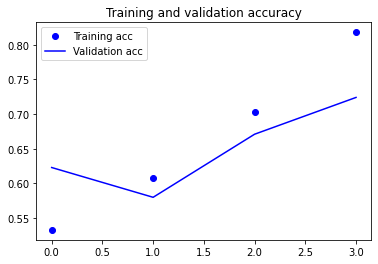

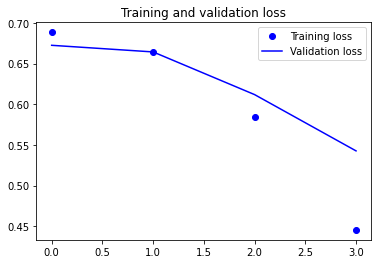

In [138]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()